# <div align="center"> CODEX: Coverage of Data Explorer </div>
The Coverage of Data Explorer (CODEX) tool is a Python package that implements data coverage metrics and algorithms for artificial intelligence (AI)/machine learning (ML) test and evaluation (T&E) applications. CODEX’s metrics are based on the theory of combinatorial testing (CT) adapted from software testing to AI/ML T&E with a data-centric focus. 

As a data assurance tool, CODEX requires datasets for all functionalities. Some functionalities additionally require ML training algorithms and a mechanism for automatically training models and evaluating them on a test set (a test harness). CODEX provides functionalities such as:

- Evaluation of the coverage of a defined universe by a dataset, which may be used for applications such as selecting a model for deployment domain
- Between dataset coverage, which may be used for applications such as computing the difference between a test and training set to generate representative and challenging test sets
- Systematic inclusion/exclusion framework (SIE), which is used for identification of critical metadata factors
- Data splitting algorithms, which may be used to construct balanced data sets for training or testing. The SIE framework uses the data splitting algorithm for constructing a balanced universal test set. In the future, this framework could use the same algorithm to produce training sets that are not only covering but also balanced. 
- Prioritization of samples to best cover a space, which may be used to support high information gain in resource restricted scenarios such as labeling and retraining

# Quickstart

### Prerequisites
CODEX requires Python 3. CODEX requires multiple packages including `pandas`, `numpy`, and `matplotlib`. Knowing Python helps, especially with dictionary formatting.

### Learning Objectives
After following this notebook, you should be able to:
- Understand the concept of a CODEX environment and the input materials it might contain.
- Understand the concept of a universe and how to construct one through binning file.
- Know how to complete a CODEX configuration/input file for an experiment.
- Find and view the outputs of a completed experiment.

### Install

Dependencies for CODEX are automatically installed when installing `codex` as a library:
```
python -m pip install <codex root directory>
```
Alternatively, dependencies for CODEX can be installed with `requirements.txt`:
```
python -m pip install -r <codex root directory>/requirements.txt
```

### Usage
CODEX can be imported as a Python module in another Python file with `import codex.codex as codex` or directly from running `python codex/codex.py` as the entry point. 

In this notebook, we opt to run CODEX as a module.

In [1]:
!python -m pip install ../

import os
import json
import pandas as pd
from PIL import Image

import learn_codex_utils as utils
import codex.codex as codex

Defaulting to user installation because normal site-packages is not writeable
Processing /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/codex_nsi
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for codex: filename=codex-2024.1.1-py3-none-any.whl size=101648 sha256=a982043d0e798a57907044be2c5c4db1e23a47efde12b7ca2972147220a13129
  Stored in directory: /tmp/pip-ephem-wheel-cache-6oofa7vr/wheels/91/0e/1a/c7123871a937d1740077231369536e3f7730e6fc6a2fc15764
Successfully built codex
  Attempting uninstall: codex
    Found existing installation: codex 2024.1.1
    Uninstalling codex-2024.1.1:
      Successfully uninstalled codex-2024.1.1


/home/hume-users/leebri2n/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### CODEX Environment
A CODEX environment is a directory that serves as a hub to organize input materials and as a landing spot for the outputs and artifacts resulting from experiments. Because leverages a variety of files whose paths are specified by the user in the input file, the concept of a CODEX "environment" can prove useful. 
    
> It is best used when each CODEX environment contains the materials for each use-case, e.g., environments for experiments about the IRIS dataset are separate from those on the Titanic datset.

At most, a proper CODEX directory contains:
- Config files: `.json` files containing input parameters to run an experiment.
- Binning files: `.txt` files specifying features and values or bins of values appearing in the data.
- Split files: `.json` files containing sample ID's reflecting sample ID's from the dataset for each split.
- Performance files: `.json` files containing overall and per-sample performance metrics on the dataset.

CODEX comes with its own function that sets up a generic environment through `setup_new_codex_env()`

In [2]:
codex_dir = codex.setup_new_codex_env("new", templates=True, tutorial=True)

new_3/
├── binning/
│   ├── binning_abstract.txt
│   ├── binning_rareplanes-complete_EX.txt
│   └── binning_TEMPLATE.txt
├── configs/
│   ├── configs_abstract_example.json
│   ├── configs_rareplanes_example.json
│   ├── configs_rareplanes_example_dse.json
│   └── configs_TEMPLATE.json
├── data/
│   ├── dataset_abstract_EX.csv
│   ├── dataset_abstract_EX_Binned.csv
│   └── dataset_rareplanes_lightweight_EX.csv
├── performance/
│   └── performance_TEMPLATE.json
├── runs/
├── splits/
│   └── splits_TEMPLATE.json
└── universe/
    ├── universe_abstract.json
    └── universe_TEMPLATE.json


### Input Materials
#### Dataset
As mentioned, CODEX is a tool that implements data coverage metrics and algorithms for machine learning test and evaluation applications with a data-centric focus. Because of the combinatorial framework of CODEX, a tabular dataset is required, where rows are samples and columns are dataset features.

Below is an example.

In [3]:
display(pd.read_csv(os.path.join(codex_dir, "data", "dataset_abstract_EX.csv")))

,id,A,B,C,D,label
0,0,a2,17.794,c2,d4,l3
1,1,a2,13.679,c3,d3,l2
2,2,a1,11.782,c1,d1,l1
3,3,a2,22.230,c3,d3,l1
4,4,a2,23.236,c2,d1,l1
...,...,...,...,...,...,...
995,995,a1,14.672,c3,d1,l2
996,996,a1,11.013,c2,d1,l1
997,997,a1,17.988,c1,d4,l1
998,998,a1,26.274,c1,d4,l1


#### Binning file and constructing a universe
Combinatorial coverage metrics for a dataset are computed with respect to a defined universe that describes the dataset in terms of discrete features values. As a result, continuous features must be binned. This is accomplished through the binning file, a `.txt` file specifies features and levels through the data.
- Continuous variables can be given variable bin size for semantic significance
- Categorical features can be ordered for semantic significance

Some notes about the binning file:
- Features specified in the binning file must contain at minimum the features specified in the input file.
- Bins for continuous variables must the entire inclusive interval of minimum and maximum values appearing for a continuous feature.
- All levels of a categorical feature that appear in the dataset must be listed.
- Formatting:
    - Features are specified on each line, separated from its values with a colon (':').
    - Values are specified following, separated from its values with semicolons (';').

CODEX parses the binning file to construct the universe of features and feature values, and then rewrites the dataset according to the new binned data.

<!-- 1) Learning from dataset: Upon reading in the dataset, the universe is constructed by treating each appearing unique value for a feature as a level in the universe. Note that for this method, discretizing continouous features by uniqueness of values can result in an infinite amount levels for a continuous feature.
2) Using a previous universe: Universes from a CODEX experiment can be saved. Whether user-written or from a previous universe, providing a directory or file path to the universe file through the input file, the universe for one experiment can applied to any other. 
3) Binning file: A separate text file known as the binning file specifying the binning scheme of features and values can be provided to construct the universe.
- A major advantage of this method lies in the semantic meaning the user can apply in the binning schemes. Continuous variables can have customized bins depending on the nature of the feature, and categorical variables can be reordered for more meainingful order (e.g., ordering 'Spring', 'Summer', 'Fall', 'Winter', the feature 'Season' rather than the order it appears in the dataset). 
    
For methods 2) and 3), these methods of universe construction are valid so long as:
- No feature or value exists in the dataset that does not exist in  while option `use_augmented_universe` is off. If `use_augmented_universe` is on, features and/or values expand the current universe.
- Bins for continuous features at minimum cover the range of values that appear in dataset, meaning maximum and minimum are included. -->


#### Example: Binning file and the resulting universe and dataset

Observe that feature B in the dataset is now binned.

*open unbinned, show binning, resulting universe, final binned file

In [4]:
binning = os.path.join("..", "resources", "tutorial", "binning_abstract.txt")
dataset_unbinned = os.path.join(
    "..", "resources", "tutorial", "dataset_abstract_EX.csv"
)

with open(os.path.join(binning)) as f:
    print(f.read())

universe, dataset_binned = codex.binning.binfile(
    dataset_unbinned, binning, ["A", "B", "C"]
)
display(universe)
display(pd.read_csv(dataset_binned, index_col="id"))

A: a1;a2
B: [0,10];(10,20];(20,50]
C: c1;c2;c3
D: d1;d2;d3;d4


{'features': ['A', 'B', 'C'],
 'levels': [['a1', 'a2'],
  ['[0,10]', '(10,20]', '(20,50]'],
  ['c1', 'c2', 'c3']]}

,A,B,C,D,label
id,,,,,
0,a2,"(10,20]",c2,d4,l3
1,a2,"(10,20]",c3,d3,l2
2,a1,"(10,20]",c1,d1,l1
3,a2,"(20,50]",c3,d3,l1
4,a2,"(20,50]",c2,d1,l1
...,...,...,...,...,...
995,a1,"(10,20]",c3,d1,l2
996,a1,"(10,20]",c2,d1,l1
997,a1,"(10,20]",c1,d4,l1


# Running CODEX
When input materials are formulated, they then must be gathered by an input file, where CODEX can run experiments on them. Below are examples of how CODEX would be used on a real dataset.

## RarePlanes
RarePlanes is an open source dataset published by In-Q-Tel consisting of real and synthetic overhead satellite imagery of planes. In the real dataset, 253 satellite images are distributed among 8,525 image tiles. RarePlanes also includes a metadata table for each of the 253 images, which can be used for CODEX.

Below is an example of one such tile, along with its associated metadata as it would appear in the `.csv` dataset.

*img -> slide, csv remians in resources/
*mention preprocessing

,image_id,loc_id,Country,State_Province,Air_Field,Latitude,Longitude,Weather,Time_of_Day,Hour_of_Day,Season,avg_sun_elevation_angle,off_nadir_max,avg_pan_resolution,biome,realm,CONTROL
image_tile_id,,,,,,,,,,,,,,,,,
84_1040010049B46C00_tile_202,84_1040010049B46C00,84,USA,Florida,Fort Lauderdale-Hollywood International Airport,26.072017,-80.150997,Cloud Cover or Haze,Day,12.183333,Spring,54.206795,28.06292,0.37769,Flooded Grasslands & Savannas,Neotropic,3


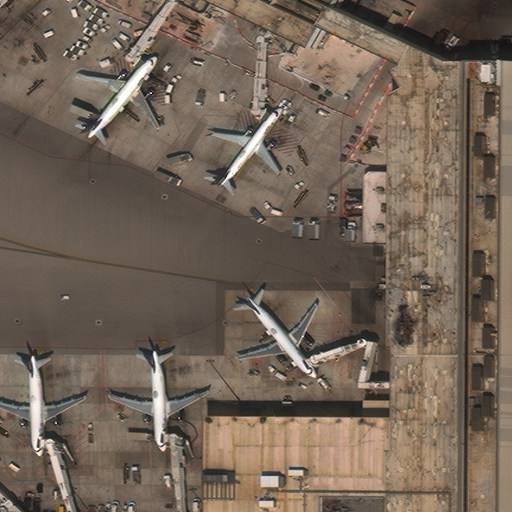

In [5]:
rareplanes_df = pd.read_csv(
    os.path.join(codex_dir, "data", "dataset_rareplanes_lightweight_EX.csv"),
    index_col="image_tile_id",
)

display(rareplanes_df.loc[["84_1040010049B46C00_tile_202"]])
display(Image.open(os.path.join("..", "resources", "84_1040010049B46C00_tile_202.png")))

### Dataset evaluation | RarePlanes
We will now see how CODEX can be applied to a dataset such as RarePlanes. One mode of CODEX, `dataset_evaluation`, computes combinatorial coverage (CC) of the dataset over the defined universe. `dataset_evaluation` is a mode suited survey the dataset for completeness with CC and to find what $t$-way interactions, if any, are missing.

Below is a glance at what a config file looks like for this experiment on RarePlanes.

In [6]:
with open(os.path.join(codex_dir, "configs", "configs_rareplanes_EX.json")) as f:
    input_rareplanes = json.load(f)

    input_rareplanes["codex_directory"] = codex_dir
    input_rareplanes["output_directory"] = codex_dir
    input_rareplanes["bin_directory"] = os.path.join(codex_dir, "binning")
    input_rareplanes["data_directory"] = os.path.join(codex_dir, "data")

    display(input_rareplanes)

{'mode': 'dataset evaluation',
 'codex_directory': '/home/hume-users/leebri2n/PROJECTS/dote_1070-1083/codex_nsi/__tutorials__/new_2',
 'output_directory': '/home/hume-users/leebri2n/PROJECTS/dote_1070-1083/codex_nsi/__tutorials__/new_2',
 'config_id': 'example_dataset_eval-0',
 'dataset_name': 'RarePlanes',
 'model_name': '',
 'data_directory': '/home/hume-users/leebri2n/PROJECTS/dote_1070-1083/codex_nsi/__tutorials__/new_2/data',
 'dataset_file': 'dataset_rareplanes_lightweight_EX.csv',
 'features': ['Hour_of_Day',
  'Season',
  'off_nadir_max',
  'avg_pan_resolution',
  'biome',
  'CONTROL'],
 'bin_directory': '/home/hume-users/leebri2n/PROJECTS/dote_1070-1083/codex_nsi/__tutorials__/new_2/binning',
 'bin_file': 'binning_rareplanes-complete_EX.txt',
 'sample_id_column': 'image_tile_id',
 'universe_directory': None,
 'universe': None,
 'use_augmented_universe': False,
 'counting_mode': 'label_exclusive',
 't': [1, 2, 3],
 'timed_output': False}

Note that the mode of experimentation, file paths, features, and values for $t$ are specified. `dataset_evaluation` can be run. View the results in output directory to view the evaluation of the dataset.

In [ ]:
results = codex.run(input_rareplanes)

# * label the CC plots, including missing cases, color coding

DATASET PATH: /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/codex_nsi/__tutorials__/new_2/data/dataset_rareplanes_lightweight_EX.csv True
Results saved to /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/codex_nsi/__tutorials__/new_2/example_dataset_eval-0.


### Dataset Split Evaluation(Performance by interaction?) | RarePlanes 
As modes of CODEX become more detailed and interesting, extra components are required as input. `dataset_split_evaluation` computes set difference combinatorial coverage (SDCC) between two portions of the dataset over the defined universe to describe the relationship between these splits, namely training, test, and/or validation splits as used in machine learning. `dataset_split_evaluation` characterizes the differences between two splits, including SDCC as a measure of distance as well as interactions that are present in one while missing in the other.

`dataset_split_evaluation`'s computation over two separate portions of a dataset requires a way to provide which samples belong to each portion. The *split file* can be provided, which identifies the sample ID's, as they appear in the dataset, that belong to each split.

In [9]:
train_ids = []
val_ids = []
test_ids = []

split = {"train": train_ids, "validation": val_ids, "test": test_ids}
codex.output.output_json_readable(
    split,
    write_json=True,
    file_path=os.path.join(codex_dir, "splits", "split_example.json"),
)

input_rareplanes["mode"] = "dataset split evaluation"
input_rareplanes["split_folder"] = "splits"
input_rareplanes["split_file"] = "original_split.json"
input_rareplanes["performance_folder"] = "performance"
input_rareplanes["split_folder"] = None
input_rareplanes["metric"] = None

`dataset_split_evaluation()` can be run. View the results in output directory to view the evaluation of the dataset.

In [10]:
results = codex.run(input_rareplanes)

KeyError: 'performance_file'

## Trying it yourself

### Dataset evaluation
With all the moving parts of CODEX, running an experiment might require hands-on usage. For simplicty, we revisit the abstract dataset to use for `dataset_evaluation`.

In [ ]:
df_path = os.path.join(codex_dir, "data", "dataset_abstract_EX.csv")
abstract = pd.read_csv(df_path, index_col="id")
display(abstract)

#### Task 1: Select features from the dataset to compute coverage over.*

In [ ]:
# Choose feature names as they appear in the dataset to compute coverage over.
features = ["A", "B", "C"]  # Use for actual release -> ['<FEATURE_NAME (str)>']

Examine the values that appear for the chosen features. This is necessary for specifying levels of categorical features and deciding bins for continuous features. 
    * Show options w binning custom
    * Prompts for each task

In [ ]:
utils.describe_feature_list(abstract, features)
# * Manual examination -> explore binning schemes by knowing, so explicitly list options
# Choice of bin by knowledge/sme
#

#### *Task 2: Write a valid binning file for the chosen features.*

Recall the binning file constraints:

"
- Features specified in the binning file must contain at least all the feature list as specified in the input file.
- Bins for continuous variables must the entire inclusive interval of minimum and maximum values appearing for a continuous feature.
- Format
    - Features are specified on each line, separated from its values with a colon (':').
    - Values are specified following, separated from its values with semicolons (';').
- All possible levels of categorical variables must be specified for a feature.

"

With the known information above, formulate levels and bins for each of features that you chose. 

In [ ]:
# Format: feature_X = "feature_X: <x level 1>;<x level 2>;..."
feature_A = ""
feature_B = ""
feature_C = ""
feature_D = ""

With these features in the correct format, we can write them into a binning file.

In [ ]:
bin_lines = [feature_A, feature_B, feature_C, feature_D]
custom_bin_file = utils.write_binning_file(abstract, features, bin_lines, codex_dir)

with open(custom_bin_file) as f:
    print(f.read())

We can test if this binning file is in the correct format if the universe constructs.

In [ ]:
universe = codex.binning.binfile(dataset_unbinned, custom_bin_file, features)
display(universe)

Lastly, the input file for CODEX requires that all the materials required to run the experiment are specified. For `dataset evaluation`, the minimum requirements include:

- `config_id`
- `data_directory`
- `data_filename`
- `bin_directory`
- `bin_file`
- `t`: List of strengths of t-way interactions to compute coverage over: i.e., [t=1, t=2, etc..]


Consider the layout of the CODEX directory.

In [ ]:
utils.display_directory(codex_dir)


Consider the config file stored under `<codex_directory>/configs/configs_rareplanes_EX.json`. Edit fields that are required above using knowledge of input materials.

In [ ]:
input_abstract = {
    "mode": "dataset evaluation",
    "codex_directory": "<!>",
    "output_directory": "",
    "config_id": "<!>",
    "dataset_name": "Abstract Dataset",
    "model_name": None,
    "data_directory": "",
    "dataset_file": "<!>",
    "features": [],
    "t": ["<!>"],
    "bin_directory": "<!>",
    "bin_file": "<!>",
    "sample_id_column": "id",
    "universe_directory": None,
    "universe": None,
    "use_augmented_universe": False,
    "counting_mode": "label_exclusive",
    "timed_output": False,
}

In [ ]:
codex.run(input_abstract)

## Dataset split eval **
- Different t*
- Sort data by a feature -> how affects split * create sorted abstract version
    - Missing chunk resides in diff region
- Random split ver *